<a href="https://colab.research.google.com/github/misha345a/SpaCy_BioNER_Transformers/blob/main/SpaCy_Relation_Parser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 %%capture
!pip install --upgrade spacy
!python -m spacy download en_core_web_sm

In [ ]:
# library imports
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
import re

import nltk
from nltk.tokenize import sent_tokenize
nltk.download('punkt')

import spacy
from spacy import displacy
from spacy.matcher import Matcher 
from spacy.tokens import Span 

# initiate tqdm for pandas.apply() functions
tqdm_notebook.pandas()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
nlp = spacy.load('en_core_web_sm')

## Data Preprocessing & Cleaning

In [ ]:
# load the dataset
df = pd.read_csv('PATH_TO_DATA.csv', lineterminator='\n', usecols=range(6))

In [ ]:
# drop irrelevant columns and rows w/ missing data
df = df[['transcription', 'keywords']].copy(deep=True)
df.dropna(how='any', inplace=True)

In [ ]:
def text_cleaning(text):
  text = re.sub(r"NOTE,:.+", "", text, flags=re.IGNORECASE) # remove transcription disclaimers
  text = re.sub(r"[A-Z]{4,}:\s?,", "", text)  # remove subheadings (PROCEDURE, IMPRESSION, etc.)
  text = re.sub(r"\d\.", "", text) # remove number lists (1., 2.)
  text = re.sub(r"([:.])\s{0,},", r"\1 ", text) # remove instances of ".," or ": ,"
  text = re.sub(",$", "", text) # remove trailing commas
  text = re.sub(r"\s{2,}", " ", text) # shorten lengthy spacing 
  text = text.lower().strip()
  return text

In [ ]:
df['keywords'] = df['keywords'].apply(text_cleaning)
df['transcription'] = df['transcription'].apply(text_cleaning)

## Extraction

In [ ]:
corpus = []
entity_pairs = []

def extract_entity_pairs(text, kw_list):
  """
  Extract sentences that contain 2 keywords.
  Append those keywords as a pair to a list.
  """
  sentences = sent_tokenize(text)
  kw_list = kw_list.split(", ")

  for sent in sentences:
    ent1 = ""
    ent2 = ""
    counter = 0
    for kw in kw_list:
      if kw in sent and counter == 0:
        ent1 += kw
        counter+=1
        continue
      if kw in sent and counter == 1:
        ent2 += kw
        entity_pairs.append([ent1, ent2])
        corpus.append(sent)
        counter+=1

In [ ]:
%%capture
df.apply(lambda x: extract_entity_pairs(x['transcription'], x['keywords']), axis=1)

In [ ]:
print("Length corpus:", len(corpus))
print("Num. entity pairs:", len(entity_pairs))

Length corpus: 21493
Num. entity pairs: 21493


In [ ]:
def get_relation(sent):
  """
  Retrieve relations (i.e. is, with, used, caused)
  by utilizing SpaCy POS tagging.
  """
  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  # define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", [pattern]) 

  matches = matcher(doc)
  k = len(matches) - 1

  try:
    span = doc[matches[k][1]:matches[k][2]] 
  except:
    return ''

  return(span.text)

In [ ]:
relations = [get_relation(i) for i in tqdm(corpus)]

100%|██████████| 21493/21493 [03:53<00:00, 92.10it/s]


## Analyze Relations

In [ ]:
# view top relations by value count
pd.Series(relations).value_counts()[:10]

is            1242
was            548
used           446
left           387
performed      283
had            212
noted          211
removed        197
identified     187
has            177
dtype: int64

In [ ]:
from wordcloud import WordCloud

def generate_wordcloud(text):
    """
    Generate word cloud images.
    """
    wordcloud = WordCloud(collocations=False, 
                          background_color="black",
                          max_words=50).generate(text)
    
    # set the figure size
    plt.figure(figsize=[8,10])

    # plot the wordcloud
    plt.imshow(wordcloud, interpolation="bilinear")

    # remove plot axes
    plt.axis("off")

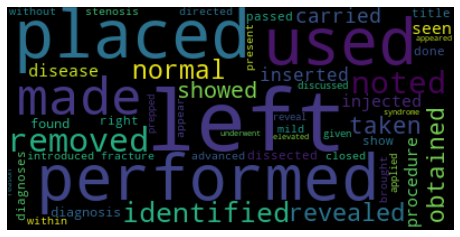

In [ ]:
# WordCloud of top 50 most frequent relations
generate_wordcloud(" ".join(relations))

## Graph Entity Relations

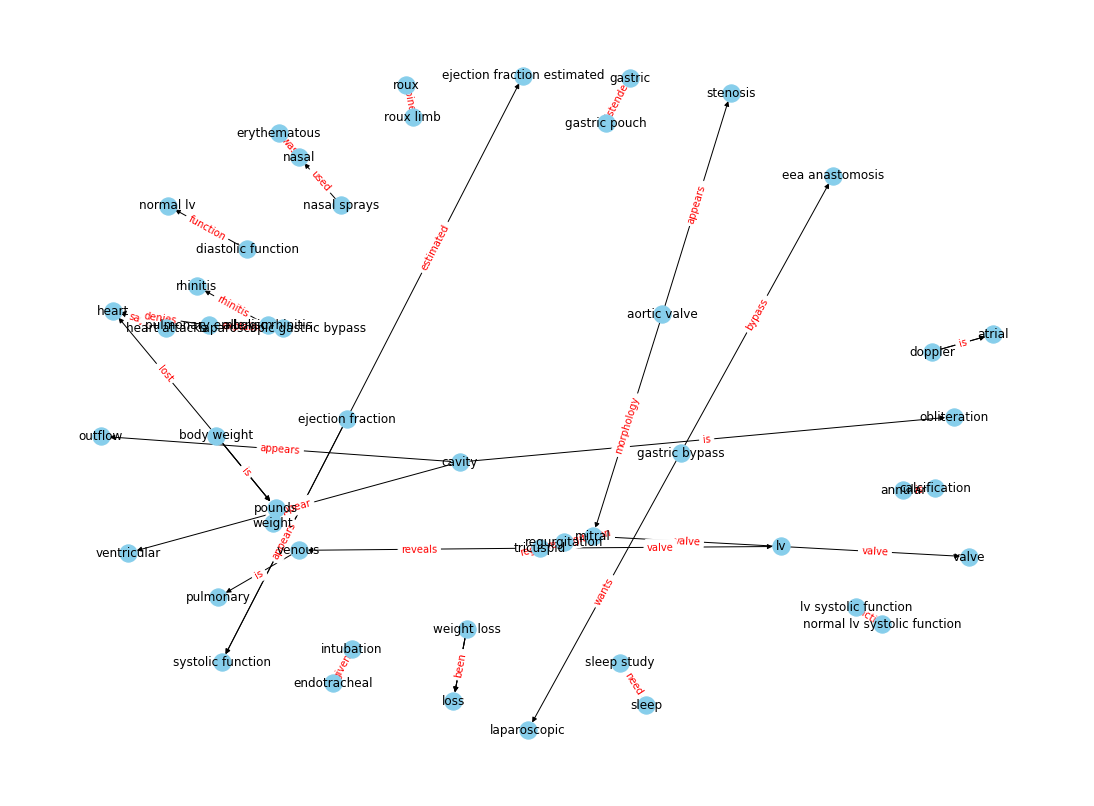

In [ ]:
# trim to top 50 relations
entity_pairs_50 = entity_pairs[:50]
relations_50 = relations[:50]

# structure a dictionary edge labels
edge_dict = {}
for i in range(50):
  entity_set = (entity_pairs_50[i][0], entity_pairs_50[i][1])
  relation = relations_50[i]
  edge_dict[entity_set] = relation.split()[0]

# extract subject and object
source = [i[0] for i in entity_pairs_50]
target = [i[1] for i in entity_pairs_50]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations_50})

# create a directed-graph from a DataFrame
G = nx.from_pandas_edgelist(kg_df, "source", "target", 
                            edge_attr=True, 
                            create_using=nx.MultiDiGraph())
                          
# plot graph
plt.figure(figsize=(15,11))
pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, 
        node_color='skyblue', 
        edge_cmap=plt.cm.Blues, 
        pos=pos)

# add edge labels
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_dict, label_pos=0.50, font_color='red')

plt.axis('off')
plt.show()